In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
df=pd.read_csv("Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
df.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,102001,0,United States,country,NaN,123328.165417,123545.139196,123814.218630,124391.341197,125055.540080,...,365372.217349,366007.694288,366471.281294,366193.660206,365661.222907,364970.033287,364347.749809,363917.639079,363688.149053,363931.687425
1,394913,1,"New York, NY",msa,NY,222096.674116,223040.459669,223992.986378,225923.174072,227921.950272,...,696533.300128,697633.014562,698948.623497,700676.336950,703154.623667,704955.084297,706457.122100,707650.653457,708454.797763,709880.464236
2,753899,2,"Los Angeles, CA",msa,CA,222620.175787,223448.605299,224552.065508,226747.580645,229148.785908,...,968173.703124,968714.163371,966675.169598,961554.657443,957217.264182,952421.630548,948047.015396,945442.656758,944366.276929,945428.022538
3,394463,3,"Chicago, IL",msa,IL,155857.310945,156001.589412,156276.370294,156959.956841,157782.229234,...,332649.038316,334015.386374,335383.265039,336242.517133,336852.936258,337148.112023,337514.741114,338367.259828,339378.680707,340732.680569
4,394514,4,"Dallas, TX",msa,TX,128023.642757,128080.664935,128146.217766,128316.451582,128540.900207,...,377150.293426,376619.688458,375829.848426,374322.685671,372189.097900,369765.587859,367394.345281,365371.532830,364005.278732,363356.229199


In [14]:
df_long = df.melt( id_vars=["RegionID", "SizeRank", "RegionName", "RegionType","StateName"],var_name="date",value_name="price")
df_long ['date'] = pd.to_datetime(df_long['date'])
df_long = df_long.sort_values(by=['RegionName','date']).reset_index(drop=True)
df_long = df_long.dropna(subset=['price']).reset_index(drop=True) 
df_long.head(10)                       

,RegionID,SizeRank,RegionName,RegionType,StateName,date,price
0,394297,677,"Aberdeen, SD",msa,SD,2009-02-28,131699.278725
1,394297,677,"Aberdeen, SD",msa,SD,2009-03-31,131712.678222
2,394297,677,"Aberdeen, SD",msa,SD,2009-04-30,131512.197622
3,394297,677,"Aberdeen, SD",msa,SD,2009-05-31,131398.694590
4,394297,677,"Aberdeen, SD",msa,SD,2009-06-30,131200.786259
5,394297,677,"Aberdeen, SD",msa,SD,2009-07-31,131060.974225
6,394297,677,"Aberdeen, SD",msa,SD,2009-08-31,130840.726137
7,394297,677,"Aberdeen, SD",msa,SD,2009-09-30,130618.896913
8,394297,677,"Aberdeen, SD",msa,SD,2009-10-31,130522.943449
9,394297,677,"Aberdeen, SD",msa,SD,2009-11-30,130464.732879


In [20]:
df_long['year'] = df_long['date'].dt.year
df_long['month']=df_long['date'].dt.month

df_long['lag_1']=df_long.groupby('RegionName')['price'].shift(1)
df_long['lag_3']=df_long.groupby('RegionName')['price'].shift(3)
df_long['lag_6']=df_long.groupby('RegionName')['price'].shift(6)

df_long['rolling_3']=df_long.groupby('RegionName')['price'].rolling(3).mean().reset_index(0,drop=True)
df_long=df_long.dropna().reset_index(drop=True)
df_long.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,date,price,year,month,lag_1,lag_3,lag_6,rolling_3
0,394297,677,"Aberdeen, SD",msa,SD,2009-08-31,130840.726137,2009,8,131060.974225,131398.694590,131699.278725,131034.162207
1,394297,677,"Aberdeen, SD",msa,SD,2009-09-30,130618.896913,2009,9,130840.726137,131200.786259,131712.678222,130840.199092
2,394297,677,"Aberdeen, SD",msa,SD,2009-10-31,130522.943449,2009,10,130618.896913,131060.974225,131512.197622,130660.855500
3,394297,677,"Aberdeen, SD",msa,SD,2009-11-30,130464.732879,2009,11,130522.943449,130840.726137,131398.694590,130535.524414
4,394297,677,"Aberdeen, SD",msa,SD,2009-12-31,130496.627456,2009,12,130464.732879,130618.896913,131200.786259,130494.767928


In [43]:
train = df_long[df_long['date'] < '2024-01-01']
test = df_long[df_long['date'] >='2024-01-01']

X_train = train[['lag_1','lag_3','lag_6','rolling_3','year','month']]
X_test  = test[['lag_1', 'lag_3', 'lag_6', 'rolling_3', 'year', 'month']]

y_train = train['price']
y_test= test['price']


In [37]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [42]:
preds = model.predict(X_test)

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test,preds)
rmse= np.sqrt(mean_squared_error(y_test,preds))

print(f"MAE: {mae:.2f}")
print(f"RMSE:{rmse:.2f}") 
        
              

MAE: 582.86
RMSE:2232.60


In [50]:
import pandas as pd
import numpy as np

dates_2026 = pd.date_range(start="2026-01-01", end = "2026-12-01",freq="MS")
cities = df_long['RegionName'].unique()
preds_2026 = []

for city in cities:
    last_data = df_long[df_long['RegionName'] == city].sort_values('date').iloc[-6:].copy()
    for date in dates_2026:
        lag_1 = last_data['price'].iloc[-1]
        lag_3 = last_data['price'].iloc[-3]
        lag_6 = last_data['price'].iloc[-6]
        rolling_3 = last_data['price'].iloc[-3:].mean()
        year = date.year
        month = date.month
        
        
        X_pred = pd.DataFrame([[lag_1, lag_3, lag_6, rolling_3, year, month]], 
        columns=['lag_1','lag_3','lag_6','rolling_3','year','month'])
        price_pred = model.predict(X_pred)[0]
        preds_2026.append([city, date, price_pred])
        
        
        new_row = pd.DataFrame({'RegionName':[city], 'Date':[date], 'Price':[price_pred]})
        last_data = pd.concat([last_data, new_row], ignore_index=True)

        df_preds_2026 = pd.DataFrame(preds_2026, columns=['RegionName','Date','PredictedPrice'])



In [55]:
df_preds_2026 = pd.DataFrame(preds_2026, columns=['RegionName','Date','PredictedPrice'])


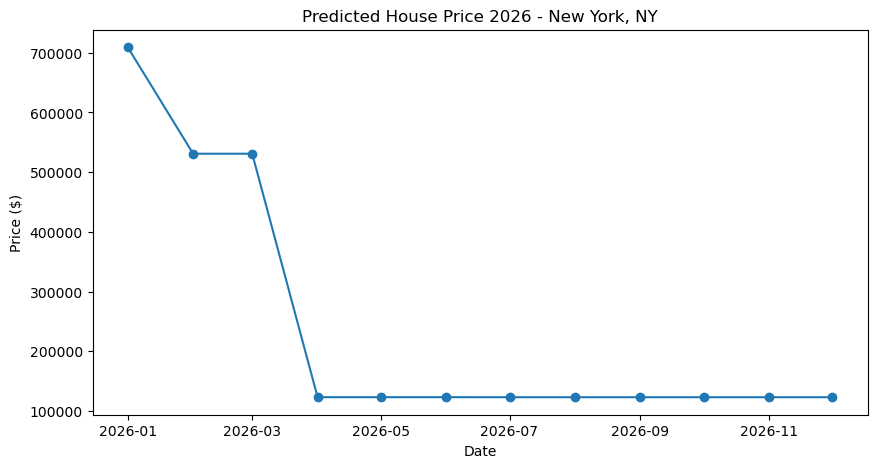

In [57]:
import matplotlib.pyplot as plt

city_name ='New York, NY'
city_data = df_preds_2026[df_preds_2026['RegionName'] == city_name]

plt.figure(figsize=(10,5))
plt.plot(city_data['Date'],city_data['PredictedPrice'], marker='o')
plt.title(f"Predicted House Price 2026 - {city_name}")
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.savefig("Predicted_House_Prices_2026.png", dpi=300)  
plt.show()